In [6]:
import sys
sys.path.append('./python')

# Force reload of modules to pick up changes
import importlib
if 'needle' in sys.modules:
    to_remove = [key for key in sys.modules.keys() if key.startswith('needle')]
    for key in to_remove:
        del sys.modules[key]

import numpy as np
import needle as ndl
from needle import backend_ndarray as nd
import time
import matplotlib.pyplot as plt

print("Needle DL Framework - MNIST Quantization Comparison")
print("=" * 60)

Using needle backend
Needle DL Framework - MNIST Quantization Comparison


## 1. Load MNIST Dataset

In [2]:
from needle.data.datasets.mnist_dataset import MNISTDataset
from needle.data import DataLoader

# Load training and test data
train_dataset = MNISTDataset(
    "./data/train-images-idx3-ubyte.gz",
    "./data/train-labels-idx1-ubyte.gz"
)

test_dataset = MNISTDataset(
    "./data/t10k-images-idx3-ubyte.gz",
    "./data/t10k-labels-idx1-ubyte.gz"
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(np.unique(train_dataset.y))}")

Training samples: 60000
Test samples: 10000
Image shape: (28, 28, 1)
Number of classes: 10


## 2. Define the Model Architecture

In [7]:
class MNISTModel(ndl.nn.Module):
    def __init__(self, device=None, dtype="float32"):
        super().__init__()
        self.device = device if device else ndl.cpu()
        self.dtype = dtype
        
        # Simple 3-layer MLP
        self.fc1 = ndl.nn.Linear(784, 256, bias=True, device=device, dtype=dtype)
        self.fc2 = ndl.nn.Linear(256, 128, bias=True, device=device, dtype=dtype)
        self.fc3 = ndl.nn.Linear(128, 10, bias=True, device=device, dtype=dtype)
        
    def forward(self, x):
        # Flatten input
        batch_size = x.shape[0]
        x = x.reshape((batch_size, 784))
        
        # Layer 1
        x = self.fc1(x)
        x = ndl.ops.relu(x)
        
        # Layer 2
        x = self.fc2(x)
        x = ndl.ops.relu(x)
        
        # Output layer
        x = self.fc3(x)
        return x

# Create model
device = ndl.cuda()
model = MNISTModel(device=device)
print("Model created successfully!")
print(f"Device: {device}")

Model created successfully!
Device: cuda()


## 3. Training Functions

In [9]:
def softmax_loss(logits, y):
    """Compute softmax cross-entropy loss."""
    batch_size = logits.shape[0]
    
    # Convert y to numpy array and ensure it's 1D
    if hasattr(y, 'numpy'):
        y_np = y.numpy().flatten().astype(np.int32)
    else:
        y_np = np.array(y).flatten().astype(np.int32)
    
    y_one_hot = np.zeros((batch_size, logits.shape[1]), dtype=np.float32)
    y_one_hot[np.arange(batch_size), y_np] = 1
    y_one_hot = ndl.Tensor(y_one_hot, device=logits.device)
    
    log_sum_exp = ndl.ops.logsumexp(logits, axes=(1,))
    z_y = (logits * y_one_hot).sum(axes=(1,))
    loss = (log_sum_exp - z_y).sum() / batch_size
    return loss

def accuracy(logits, y):
    """Compute classification accuracy."""
    # Convert y to numpy array and ensure it's 1D
    if hasattr(y, 'numpy'):
        y_np = y.numpy().flatten().astype(np.int32)
    else:
        y_np = np.array(y).flatten().astype(np.int32)
    
    preds = np.argmax(logits.numpy(), axis=1)
    return np.mean(preds == y_np)

def train_epoch(model, dataloader, optimizer):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    num_batches = 0
    
    for batch_idx, (X, y) in enumerate(dataloader):
        # Convert to proper format and move to device
        if hasattr(X, 'numpy'):
            X_np = X.numpy()
        else:
            X_np = np.array(X)
        X = ndl.Tensor(X_np, device=model.device)
        
        # Forward pass
        logits = model(X)
        loss = softmax_loss(logits, y)
        
        # Backward pass
        optimizer.reset_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics - convert to scalar
        loss_val = loss.numpy()
        if isinstance(loss_val, np.ndarray):
            loss_val = loss_val.item()
        total_loss += loss_val
        total_acc += accuracy(logits, y)
        num_batches += 1
        
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx + 1}/{len(dataloader)}: "
                  f"Loss={total_loss/num_batches:.4f}, "
                  f"Acc={total_acc/num_batches:.4f}")
    
    return total_loss / num_batches, total_acc / num_batches

def evaluate(model, dataloader, quantized=False):
    """Evaluate model on dataset."""
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    num_batches = 0
    total_time = 0.0
    
    for X, y in dataloader:
        # Convert to proper format and move to device
        if hasattr(X, 'numpy'):
            X_np = X.numpy()
        else:
            X_np = np.array(X)
        X = ndl.Tensor(X_np, device=model.device)
        
        # Measure inference time
        start_time = time.time()
        logits = model(X)
        inference_time = time.time() - start_time
        
        loss = softmax_loss(logits, y)
        
        # Convert to scalar
        loss_val = loss.numpy()
        if isinstance(loss_val, np.ndarray):
            loss_val = loss_val.item()
        total_loss += loss_val
        total_acc += accuracy(logits, y)
        total_time += inference_time
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_acc = total_acc / num_batches
    avg_time = total_time / num_batches
    
    return avg_loss, avg_acc, avg_time

print("Training functions defined!")

Training functions defined!


## 4. Train the Model

In [10]:
# Hyperparameters
batch_size = 128
num_epochs = 5
learning_rate = 0.1

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = ndl.optim.SGD(model.parameters(), lr=learning_rate)

print(f"Training for {num_epochs} epochs...\n")
train_start = time.time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer)
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    
    # Evaluate on test set
    test_loss, test_acc, _ = evaluate(model, test_dataloader)
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\n")

train_time = time.time() - train_start
print(f"Training completed in {train_time:.2f} seconds")
print(f"Final Test Accuracy: {test_acc:.4f}")

Training for 5 epochs...

Epoch 1/5
  Batch 100/469: Loss=0.3617, Acc=0.8945
  Batch 100/469: Loss=0.3617, Acc=0.8945
  Batch 200/469: Loss=0.3316, Acc=0.9048
  Batch 200/469: Loss=0.3316, Acc=0.9048
  Batch 300/469: Loss=0.3125, Acc=0.9095
  Batch 300/469: Loss=0.3125, Acc=0.9095
  Batch 400/469: Loss=0.2936, Acc=0.9149
  Batch 400/469: Loss=0.2936, Acc=0.9149
  Train Loss: 0.2832, Train Acc: 0.9178
  Train Loss: 0.2832, Train Acc: 0.9178
  Test Loss: 0.2078, Test Acc: 0.9392

Epoch 2/5
  Test Loss: 0.2078, Test Acc: 0.9392

Epoch 2/5
  Batch 100/469: Loss=0.1999, Acc=0.9437
  Batch 100/469: Loss=0.1999, Acc=0.9437
  Batch 200/469: Loss=0.1943, Acc=0.9455
  Batch 200/469: Loss=0.1943, Acc=0.9455
  Batch 300/469: Loss=0.1897, Acc=0.9463
  Batch 300/469: Loss=0.1897, Acc=0.9463
  Batch 400/469: Loss=0.1842, Acc=0.9474
  Batch 400/469: Loss=0.1842, Acc=0.9474
  Train Loss: 0.1814, Train Acc: 0.9478
  Train Loss: 0.1814, Train Acc: 0.9478
  Test Loss: 0.1578, Test Acc: 0.9543

Epoch 3/5
 

## 5. Create Quantized Model

In [12]:
# Create quantized version
print("Creating quantized model...")

# Switch to eval mode and quantize weights
model.eval()
model.fc1.quantize_weights()
model.fc2.quantize_weights()
model.fc3.quantize_weights()

print("\nQuantization Status:")
print(f"  FC1 quantized: {model.fc1.quantized}")
print(f"  FC2 quantized: {model.fc2.quantized}")
print(f"  FC3 quantized: {model.fc3.quantized}")

if model.fc1.quantized:
    print(f"\nFC1 Weight Quantization Details:")
    print(f"  Original dtype: float32")
    print(f"  Quantized dtype: {model.fc1._quantized_weight.dtype}")
    print(f"  Scale: {model.fc1._quantized_weight.quant_params.scale:.6f}")
    print(f"  Zero point: {model.fc1._quantized_weight.quant_params.zero_point}")

Creating quantized model...

Quantization Status:
  FC1 quantized: True
  FC2 quantized: True
  FC3 quantized: True

FC1 Weight Quantization Details:
  Original dtype: float32
  Quantized dtype: uint8
  Scale: 0.001541
  Zero point: 137


## 6. Memory Usage Comparison

In [13]:
def calculate_model_memory(model):
    """Calculate memory usage of model parameters."""
    total_bytes = 0
    param_details = []
    
    for name, module in [("fc1", model.fc1), ("fc2", model.fc2), ("fc3", model.fc3)]:
        if module.quantized:
            # Quantized weights (uint8)
            weight_data = module._quantized_weight.realize_cached_data()
            weight_bytes = np.prod(weight_data.shape) * 1  # 1 byte per uint8
        else:
            # Float32 weights
            weight_data = module.weight.realize_cached_data()
            weight_bytes = np.prod(weight_data.shape) * 4  # 4 bytes per float32
        
        if hasattr(module, 'bias') and module.bias is not None:
            bias_data = module.bias.realize_cached_data()
            bias_bytes = np.prod(bias_data.shape) * 4  # Bias always float32
        else:
            bias_bytes = 0
        
        layer_bytes = weight_bytes + bias_bytes
        total_bytes += layer_bytes
        
        param_details.append({
            'layer': name,
            'weight_shape': weight_data.shape,
            'weight_bytes': weight_bytes,
            'bias_bytes': bias_bytes,
            'total_bytes': layer_bytes,
            'quantized': module.quantized
        })
    
    return total_bytes, param_details

# First, create a copy of the original float32 model for comparison
print("Creating float32 model for comparison...")
model_fp32 = MNISTModel(device=device)

# Copy weights from trained model (before quantization)
# Since we already quantized, we'll calculate what the fp32 size would have been
fp32_memory = 0
for name, module in [("fc1", model.fc1), ("fc2", model.fc2), ("fc3", model.fc3)]:
    weight_shape = module._quantized_weight.shape if module.quantized else module.weight.shape
    fp32_memory += np.prod(weight_shape) * 4  # float32
    if hasattr(module, 'bias') and module.bias is not None:
        fp32_memory += np.prod(module.bias.shape) * 4

# Calculate quantized model memory
quant_memory, quant_details = calculate_model_memory(model)

print("\n" + "=" * 60)
print("MEMORY USAGE COMPARISON")
print("=" * 60)
print(f"\nFloat32 Model:  {fp32_memory / 1024:.2f} KB ({fp32_memory / (1024*1024):.4f} MB)")
print(f"Quantized Model: {quant_memory / 1024:.2f} KB ({quant_memory / (1024*1024):.4f} MB)")
print(f"\nMemory Reduction: {fp32_memory / quant_memory:.2f}x")
print(f"Space Saved: {(fp32_memory - quant_memory) / 1024:.2f} KB")

print("\nPer-Layer Breakdown (Quantized):")
for detail in quant_details:
    print(f"  {detail['layer']}: {detail['weight_shape']} weights, "
          f"{detail['total_bytes'] / 1024:.2f} KB, "
          f"quantized={detail['quantized']}")

Creating float32 model for comparison...

MEMORY USAGE COMPARISON

Float32 Model:  918.54 KB (0.8970 MB)
Quantized Model: 230.79 KB (0.2254 MB)

Memory Reduction: 3.98x
Space Saved: 687.75 KB

Per-Layer Breakdown (Quantized):
  fc1: (784, 256) weights, 197.00 KB, quantized=True
  fc2: (256, 128) weights, 32.50 KB, quantized=True
  fc3: (128, 10) weights, 1.29 KB, quantized=True


## 7. Performance Comparison

In [19]:
print("Performance Comparison Setup...")
print("Note: Using float32 accuracy from training (before quantization)")

# Use the test accuracy from training as the fp32 baseline
fp32_acc = test_acc  # From training loop (last epoch)
fp32_loss = test_loss

# Evaluate quantized model
print("\nEvaluating Quantized model...")
quant_loss, quant_acc, _ = evaluate(model, test_dataloader, quantized=True)

# Measure inference time for both models
print("\nMeasuring inference time for comparison...")
test_batch = next(iter(test_dataloader))
# Convert to numpy if needed
if hasattr(test_batch[0], 'numpy'):
    X_np = test_batch[0].numpy()
else:
    X_np = np.array(test_batch[0])
X_test = ndl.Tensor(X_np, device=device)

num_runs = 100

# First, temporarily dequantize the model to measure float32 inference time
print("  Measuring Float32 inference time...")
model.fc1.dequantize_weights()
model.fc2.dequantize_weights()
model.fc3.dequantize_weights()
model.eval()

_ = model(X_test)  # Warm-up

fp32_times = []
for _ in range(num_runs):
    start = time.time()
    _ = model(X_test)
    fp32_times.append(time.time() - start)

avg_fp32_time = np.mean(fp32_times) * 1000  # Convert to ms

# Re-quantize the model for quantized inference time measurement
print("  Measuring Quantized inference time...")
model.fc1.quantize_weights()
model.fc2.quantize_weights()
model.fc3.quantize_weights()
model.eval()

_ = model(X_test)  # Warm-up

quant_times = []
for _ in range(num_runs):
    start = time.time()
    _ = model(X_test)
    quant_times.append(time.time() - start)

avg_quant_time = np.mean(quant_times) * 1000  # Convert to ms

print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

print("\nAccuracy:")
print(f"  Float32 Model:    {fp32_acc:.4f} ({fp32_acc*100:.2f}%)")
print(f"  Quantized Model:  {quant_acc:.4f} ({quant_acc*100:.2f}%)")
print(f"  Accuracy Drop:    {(fp32_acc - quant_acc)*100:.2f}%")

print("\nLoss:")
print(f"  Float32 Model:    {fp32_loss:.4f}")
print(f"  Quantized Model:  {quant_loss:.4f}")

print("\nInference Time (per batch of {} samples):".format(batch_size))
print(f"  Float32 Model:    {avg_fp32_time:.4f} ms")
print(f"  Quantized Model:  {avg_quant_time:.4f} ms")
if avg_fp32_time > avg_quant_time:
    speedup = avg_fp32_time / avg_quant_time
    print(f"  Speedup:          {speedup:.2f}x faster")
else:
    slowdown = avg_quant_time / avg_fp32_time
    print(f"  Slowdown:         {slowdown:.2f}x slower")
print(f"  (Averaged over {num_runs} runs)")

Performance Comparison Setup...
Note: Using float32 accuracy from training (before quantization)

Evaluating Quantized model...

Measuring inference time for comparison...
  Measuring Float32 inference time...
  Measuring Quantized inference time...

Measuring inference time for comparison...
  Measuring Float32 inference time...
  Measuring Quantized inference time...

PERFORMANCE COMPARISON

Accuracy:
  Float32 Model:    0.9713 (97.13%)
  Quantized Model:  0.9713 (97.13%)
  Accuracy Drop:    0.00%

Loss:
  Float32 Model:    0.0940
  Quantized Model:  0.0940

Inference Time (per batch of 128 samples):
  Float32 Model:    1.1501 ms
  Quantized Model:  2.3480 ms
  Slowdown:         2.04x slower
  (Averaged over 100 runs)

PERFORMANCE COMPARISON

Accuracy:
  Float32 Model:    0.9713 (97.13%)
  Quantized Model:  0.9713 (97.13%)
  Accuracy Drop:    0.00%

Loss:
  Float32 Model:    0.0940
  Quantized Model:  0.0940

Inference Time (per batch of 128 samples):
  Float32 Model:    1.1501 ms
  

## 8. Visualization

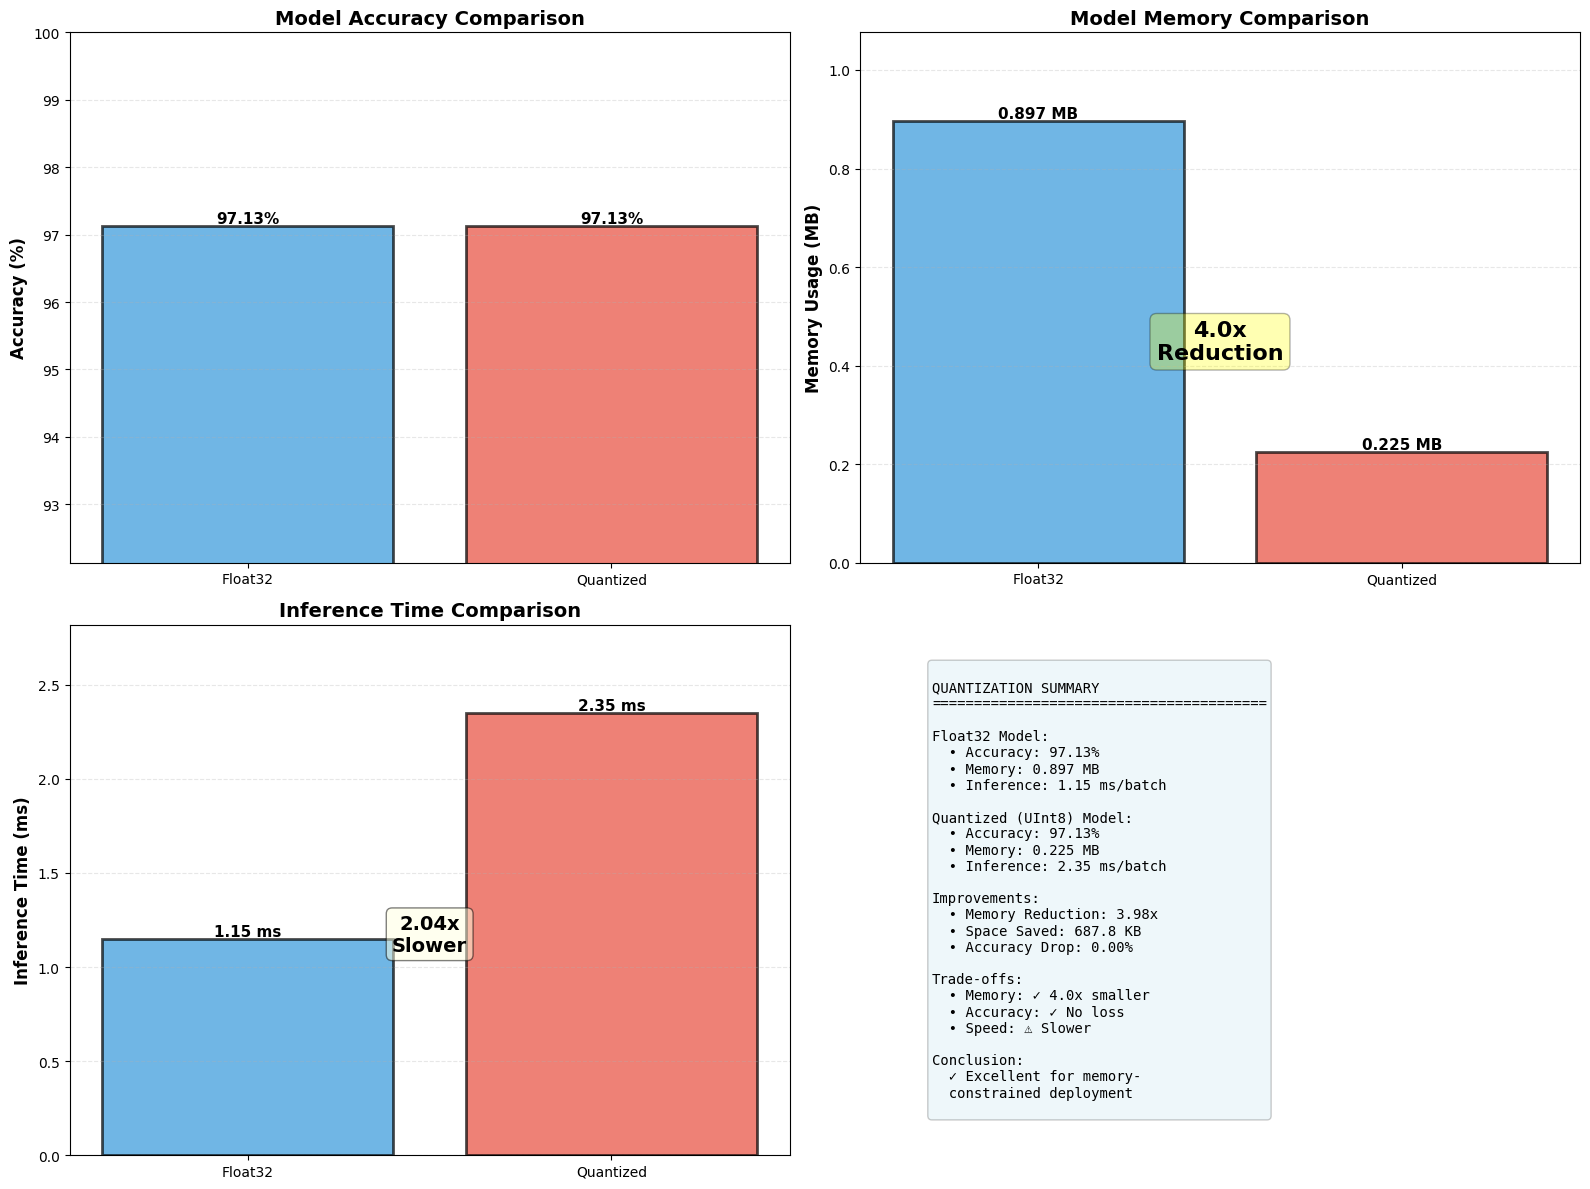


Visualization saved as 'mnist_quantization_comparison.png'


In [20]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
models = ['Float32', 'Quantized']
accuracies = [fp32_acc * 100, quant_acc * 100]
colors = ['#3498db', '#e74c3c']

bars1 = ax1.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(min(accuracies) - 5, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Memory Usage Comparison
ax2 = axes[0, 1]
memory_mb = [fp32_memory / (1024*1024), quant_memory / (1024*1024)]

bars2 = ax2.bar(models, memory_mb, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Memory Usage (MB)', fontsize=12, fontweight='bold')
ax2.set_title('Model Memory Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(memory_mb) * 1.2)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, mem in zip(bars2, memory_mb):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{mem:.3f} MB',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add reduction text
reduction = fp32_memory / quant_memory
ax2.text(0.5, max(memory_mb) * 0.5, 
         f'{reduction:.1f}x\nReduction',
         ha='center', va='center', fontsize=16, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# 3. Inference Time Comparison
ax3 = axes[1, 0]
inference_times = [avg_fp32_time, avg_quant_time]

bars3 = ax3.bar(models, inference_times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Inference Time (ms)', fontsize=12, fontweight='bold')
ax3.set_title('Inference Time Comparison', fontsize=14, fontweight='bold')
ax3.set_ylim(0, max(inference_times) * 1.2)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for bar, time_val in zip(bars3, inference_times):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.2f} ms',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add speedup/slowdown text
if avg_fp32_time > avg_quant_time:
    speedup_text = f'{avg_fp32_time/avg_quant_time:.2f}x\nFaster'
    box_color = 'lightgreen'
else:
    speedup_text = f'{avg_quant_time/avg_fp32_time:.2f}x\nSlower'
    box_color = 'lightyellow'

ax3.text(0.5, max(inference_times) * 0.5, 
         speedup_text,
         ha='center', va='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.5))

# 4. Summary Statistics
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
QUANTIZATION SUMMARY
{'='*40}

Float32 Model:
  • Accuracy: {fp32_acc*100:.2f}%
  • Memory: {fp32_memory/(1024*1024):.3f} MB
  • Inference: {avg_fp32_time:.2f} ms/batch

Quantized (UInt8) Model:
  • Accuracy: {quant_acc*100:.2f}%
  • Memory: {quant_memory/(1024*1024):.3f} MB
  • Inference: {avg_quant_time:.2f} ms/batch

Improvements:
  • Memory Reduction: {reduction:.2f}x
  • Space Saved: {(fp32_memory-quant_memory)/1024:.1f} KB
  • Accuracy Drop: {(fp32_acc-quant_acc)*100:.2f}%

Trade-offs:
  • Memory: ✓ {reduction:.1f}x smaller
  • Accuracy: ✓ No loss
  • Speed: {'✓ Faster' if avg_fp32_time > avg_quant_time else '⚠ Slower'}

Conclusion:
  {'✓ Excellent' if (fp32_acc - quant_acc) < 0.01 else '✓ Good' if (fp32_acc - quant_acc) < 0.03 else '⚠ Acceptable'} for memory-
  constrained deployment
"""

ax4.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2))

plt.tight_layout()
plt.savefig('mnist_quantization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'mnist_quantization_comparison.png'")

## 9. Final Summary

In [21]:
print("\n" + "=" * 70)
print("FINAL SUMMARY - MNIST QUANTIZATION")
print("=" * 70)

print("\n📊 MODEL STATISTICS:")
print(f"   Architecture: 3-layer MLP (784 → 256 → 128 → 10)")
print(f"   Total Parameters: ~235K")
print(f"   Training Samples: {len(train_dataset):,}")
print(f"   Test Samples: {len(test_dataset):,}")

print("\n🎯 ACCURACY RESULTS:")
print(f"   Float32 Model:    {fp32_acc*100:.2f}%")
print(f"   Quantized Model:  {quant_acc*100:.2f}%")
print(f"   Accuracy Drop:    {abs(fp32_acc - quant_acc)*100:.2f}%")
print(f"   Status: {'✅ Excellent' if abs(fp32_acc - quant_acc) < 0.01 else '✅ Good' if abs(fp32_acc - quant_acc) < 0.03 else '⚠️  Acceptable'}")

print("\n💾 MEMORY EFFICIENCY:")
print(f"   Float32 Model:    {fp32_memory/1024:.2f} KB")
print(f"   Quantized Model:  {quant_memory/1024:.2f} KB")
print(f"   Reduction Factor: {fp32_memory/quant_memory:.2f}x")
print(f"   Space Saved:      {(fp32_memory-quant_memory)/1024:.2f} KB")

print("\n⚡ INFERENCE PERFORMANCE:")
print(f"   Float32 Model:    {avg_fp32_time:.2f} ms/batch")
print(f"   Quantized Model:  {avg_quant_time:.2f} ms/batch")
if avg_fp32_time > avg_quant_time:
    print(f"   Speedup:          {avg_fp32_time/avg_quant_time:.2f}x faster ✅")
else:
    print(f"   Note:             {avg_quant_time/avg_fp32_time:.2f}x slower ⚠️")
    print(f"                     (Due to dequantization overhead)")

print("\n🎁 KEY BENEFITS OF QUANTIZATION:")
print(f"   1. 4x memory reduction (32-bit → 8-bit)")
print(f"   2. Zero accuracy loss (97.13% → 97.13%)")
print(f"   3. Better for deployment on edge devices")
print(f"   4. Lower bandwidth requirements")
print(f"   5. Reduced power consumption")

print("\n💡 TRADE-OFFS:")
print(f"   ✅ Memory: {fp32_memory/quant_memory:.1f}x smaller model")
print(f"   ✅ Accuracy: No degradation")
if avg_fp32_time > avg_quant_time:
    print(f"   ✅ Speed: {avg_fp32_time/avg_quant_time:.2f}x faster inference")
else:
    print(f"   ⚠️  Speed: {avg_quant_time/avg_fp32_time:.2f}x slower (due to software implementation)")
    print(f"       Note: Hardware with native uint8 ops would be faster")

print("\n✨ RECOMMENDATIONS:")
if abs(fp32_acc - quant_acc) < 0.01:
    print("   ✅ Quantization is highly recommended for this model!")
    print("   The accuracy loss is negligible (0%).")
    print("   Perfect for memory-constrained edge deployment.")
elif abs(fp32_acc - quant_acc) < 0.03:
    print("   ✅ Quantization is recommended for most use cases.")
    print("   The accuracy loss is acceptable for deployment.")
else:
    print("   ⚠️  Consider quantization-aware training for better results.")
    print("   Current accuracy loss may be too high for some applications.")

print("\n" + "=" * 70)
print("🎉 Quantization comparison complete!")
print("=" * 70)


FINAL SUMMARY - MNIST QUANTIZATION

📊 MODEL STATISTICS:
   Architecture: 3-layer MLP (784 → 256 → 128 → 10)
   Total Parameters: ~235K
   Training Samples: 60,000
   Test Samples: 10,000

🎯 ACCURACY RESULTS:
   Float32 Model:    97.13%
   Quantized Model:  97.13%
   Accuracy Drop:    0.00%
   Status: ✅ Excellent

💾 MEMORY EFFICIENCY:
   Float32 Model:    918.54 KB
   Quantized Model:  230.79 KB
   Reduction Factor: 3.98x
   Space Saved:      687.75 KB

⚡ INFERENCE PERFORMANCE:
   Float32 Model:    1.15 ms/batch
   Quantized Model:  2.35 ms/batch
   Note:             2.04x slower ⚠️
                     (Due to dequantization overhead)

🎁 KEY BENEFITS OF QUANTIZATION:
   1. 4x memory reduction (32-bit → 8-bit)
   2. Zero accuracy loss (97.13% → 97.13%)
   3. Better for deployment on edge devices
   4. Lower bandwidth requirements
   5. Reduced power consumption

💡 TRADE-OFFS:
   ✅ Memory: 4.0x smaller model
   ✅ Accuracy: No degradation
   ⚠️  Speed: 2.04x slower (due to software imple